<img src="header-models.PNG" class="hover-text"/>

_Credits: https://andrewprokos.com/photo/seattle-panoramic-skyline-night/_

# Running the notebook

This notebook assumes the following tree, for loading data and writing results:

```bash
├───data
│   ├───processed
│   │   ├───df_clean_lev.pkl
│   │   ├───df_clean_no_lev.pkl
│   │   ├───leverage_index.pkl
│   │   └───use_type_gfa_cols.pkl
│   └───raw
└───notebooks
    ├───1_EDA.ipynb
    ├───2_models.ipynb
    ├───header-EDA.png
    └───header-models.png
```

The `*.pkl` files come from running the `1_EDA.ipynb` notebook.

# Project initialization

Option to study the `ENERGYSTARScore` variable, which does not give the same number of samples:

In [3]:
ENERGYSTAR_STUDY = True #True

Complete lever removal option (train as test):

In [4]:
NO_LEVERAGE = False #True

Another option to remove them **only from the train set** has been developed, too.

In [15]:
# Math & data
import numpy as np
import scipy
import pandas as pd
from datetime import date
import itertools, copy
import pickle

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Feature selection
from sklearn.model_selection import GridSearchCV, KFold

# ML
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.dummy import DummyClassifier

# Neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.neural_network import MLPRegressor

In [7]:
from numpy import vstack
from numpy import sqrt

In [8]:
import skorch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn import NLLLoss
from torch.optim import SGD, Adam, LBFGS, Rprop, RMSprop, ASGD
from torch.nn import MSELoss
from torch.nn.init import xavier_uniform_
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from skorch.callbacks import EarlyStopping

In [9]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Callback

In [10]:
import shap

In [11]:
%load_ext autoreload
# reload_ext autoreload
%autoreload 2

In [12]:
# Personal libraries
import DisplotData, PwePwocess, Funktiuns, MLstuff, DisplotML
from DisplotData import bcolors

In [13]:
# Display options
pd.set_option("display.max_columns", 100) # None
pd.set_option("display.max_rows", 100) # None

In [100]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Chargement des données

In [167]:
data_raw_dir = '../data/raw/'
data_processed_dir = '../data/processed/'

In [16]:
file = open(data_processed_dir+'df_clean_lev.pkl','rb')
df_clean_lev = pickle.load(file)
file.close()

file = open(data_processed_dir+'df_clean_no_lev.pkl','rb')
df_clean_no_lev = pickle.load(file)
file.close()

file = open(data_processed_dir+'use_type_gfa_cols.pkl','rb')
use_type_gfa_cols = pickle.load(file)
file.close()

file = open(data_processed_dir+'leverage_index.pkl','rb')
leverage_index = pickle.load(file)
file.close()

In [17]:
df_clean_lev.shape

(3180, 117)

In [18]:
df_clean_no_lev.shape

(2748, 117)

# Option to take into account `'ENERGYSTARScore'`

In [19]:
NO_LEVERAGE

False

In [20]:
if ENERGYSTAR_STUDY:
    df_clean_lev    = df_clean_lev.loc[df_clean_lev['ENERGYSTARScore'].notna()].copy()
    df_clean_no_lev = df_clean_no_lev.loc[df_clean_no_lev['ENERGYSTARScore'].notna()].copy()    

# Constitution of datasets of different complexity

In view of previous studies, we can consider different simple to complex models made up of the variables:

#### Simplistic
```
'PropertyGFABuilding(s)'
```

#### Simple
```
'PropertyGFABuilding(s)',
'LargestPropertyUseType'
```

#### Medium
```
'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
'PropertyGFAParking', 'ResidualGFA'
```

#### Optimized medium
```
use_type_gfa_cols
```

#### Method 2: we stick everything else in Third and we consider that the car parks do not consume/emit anything
```
'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA+ResidualGFA'
```

#### Way 3: if after checking the Third and Residual surfaces are negligible
```
'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
'PropertyGFAParking'
```

#### Complex
```
'Neighborhood', 'YearBuilt'
'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
'PropertyGFAParking', 'ResidualGFA'
```

#### Rich complex
```
'Neighborhood', 'YearBuilt'
'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
'PropertyGFAParking', 'ResidualGFA',
'SteamUsed, 'ElecUsed', GasUsed'
```

#### Optimized complex
```
'Neighborhood', 'YearBuilt',
use_type_gfa_cols
```


#### Complexist
```
'Neighborhood', 'YearBuilt',
'NumberofBuildings', 'NumberofFloors',
'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
'PropertyGFAParking', 'ResidualGFA'
```

#### Rich complexist
```
'Neighborhood', 'YearBuilt',
'NumberofBuildings', 'NumberofFloors',
'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
'PropertyGFAParking', 'ResidualGFA',
'SteamUsed, 'ElecUsed', GasUsed'
```

#### Optimized complexist
```
'Neighborhood', 'YearBuilt',
'NumberofBuildings', 'NumberofFloors',
use_type_gfa_cols
```

#### Optimized rich complexist
```
'Neighborhood', 'YearBuilt',
'NumberofBuildings', 'NumberofFloors',
use_type_gfa_cols,
'SteamUsed, 'ElecUsed', GasUsed'
```

#### Assuming that the surfaces are not known in an exploitation permit file:
```
'PropertyGFATotal',
'PrimaryPropertyType',
'Neighborhood'
'Lease',
'BuildingType',
'NumberofBuildings',
'NumberofFloors'
```

The contribution of `'PropertyGFAParking'` in the predictions remains to be measured, too.

In [21]:
df_clean_lev = df_clean_lev.copy()
df_clean_no_lev = df_clean_no_lev.copy()
df_clean_lev['ThirdLargestPropertyUseTypeGFA+ResidualGFA'] = df_clean_lev['ThirdLargestPropertyUseTypeGFA']+df_clean_lev['ResidualGFA']
df_clean_no_lev['ThirdLargestPropertyUseTypeGFA+ResidualGFA'] = df_clean_no_lev['ThirdLargestPropertyUseTypeGFA']+df_clean_no_lev['ResidualGFA']

In [22]:
models_cols = [
#     # Simpliste
#     {'categ_cols': [],
#      'num_cols'  :['PropertyGFABuilding(s)']},
#     # Simple
#     {'categ_cols':['LargestPropertyUseType'],
#      'num_cols'  :['PropertyGFABuilding(s)']},
#     # Moyen
#     {'categ_cols':['LargestPropertyUseType', 'SecondLargestPropertyUseType',
#                    'ThirdLargestPropertyUseType'],
#      'num_cols'  :['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
#                    'ThirdLargestPropertyUseTypeGFA', 'ResidualGFA', 'PropertyGFAParking']},
#     # Moyen riche
#     {'categ_cols':['LargestPropertyUseType', 'SecondLargestPropertyUseType',
#                    'ThirdLargestPropertyUseType'],
#      'num_cols'  :['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
#                    'ThirdLargestPropertyUseTypeGFA', 'ResidualGFA', 'PropertyGFAParking',
#                    'SteamUsed', 'ElecUsed', 'GasUsed']},
#     # Moyen 2
#     {'categ_cols':['LargestPropertyUseType', 'SecondLargestPropertyUseType',
#                    'ThirdLargestPropertyUseType'],
#      'num_cols'  :['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
#                    'ThirdLargestPropertyUseTypeGFA+ResidualGFA']},
#     # Moyen 3
#     {'categ_cols':['LargestPropertyUseType', 'SecondLargestPropertyUseType'],
#      'num_cols'  :['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
#                    'PropertyGFAParking']},
#     # Moyen 3 riche
#     {'categ_cols':['LargestPropertyUseType', 'SecondLargestPropertyUseType'],
#      'num_cols'  :['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
#                    'PropertyGFAParking',
#                    'SteamUsed', 'ElecUsed', 'GasUsed']},
    # Moyen optimisé
    {'categ_cols':[],
     'num_cols'  :use_type_gfa_cols},
#     # Complexe
#    {'categ_cols' :['LargestPropertyUseType', 'SecondLargestPropertyUseType',
#                    'ThirdLargestPropertyUseType', 'Neighborhood'],
#      'num_cols'  :['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
#                    'ThirdLargestPropertyUseTypeGFA', 'ResidualGFA', 'PropertyGFAParking',
#                    'YearBuilt']},
#     # Complexe riche
#    {'categ_cols' :['LargestPropertyUseType', 'SecondLargestPropertyUseType',
#                    'ThirdLargestPropertyUseType', 'Neighborhood'],
#      'num_cols'  :['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
#                    'ThirdLargestPropertyUseTypeGFA', 'ResidualGFA', 'PropertyGFAParking',
#                    'YearBuilt',
#                    'SteamUsed', 'ElecUsed', 'GasUsed']},
#     # Complexe optimisé
#     {'categ_cols':['Neighborhood'],
#      'num_cols'  :use_type_gfa_cols+['YearBuilt']},
#     # Complexe riche optimisé
#     {'categ_cols':['Neighborhood'],
#      'num_cols'  :use_type_gfa_cols+['YearBuilt','SteamUsed', 'ElecUsed', 'GasUsed']},
#     # Complexiste
#     {'categ_cols':['LargestPropertyUseType', 'SecondLargestPropertyUseType',
#                    'ThirdLargestPropertyUseType', 'Neighborhood'],
#      'num_cols'  :['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
#                    'ThirdLargestPropertyUseTypeGFA', 'ResidualGFA', 'PropertyGFAParking',
#                    'YearBuilt', 'NumberofBuildings', 'NumberofFloors']},
#     # Complexiste riche
#     {'categ_cols':['LargestPropertyUseType', 'SecondLargestPropertyUseType',
#                    'ThirdLargestPropertyUseType', 'Neighborhood'],
#      'num_cols'  :['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
#                    'ThirdLargestPropertyUseTypeGFA', 'ResidualGFA', 'PropertyGFAParking',
#                    'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
#                    'SteamUsed', 'ElecUsed', 'GasUsed']},
#     # Complexiste optimisé
#     {'categ_cols':['Neighborhood'],
#      'num_cols'  :use_type_gfa_cols+['YearBuilt', 'NumberofBuildings', 'NumberofFloors']},

#     # Complexiste riche optimisé (= top)
#     {'categ_cols':['Neighborhood'],
#      'num_cols'  :use_type_gfa_cols+['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
#                                      'SteamUsed', 'ElecUsed', 'GasUsed']},
    
#     # Surfaces supposées inconnues dans le dossier d'exploitation
#     {'categ_cols':['PrimaryPropertyType',
#                    'Neighborhood',
#                    'BuildingType'],
#      'num_cols'  :['PropertyGFATotal',
# #                    'Latitude', 'Longitude',
#                    'NumberofBuildings',
#                    'NumberofFloors']},
#     {'categ_cols':['PrimaryPropertyType',
# #                    'Neighborhood',
#                    'BuildingType'],
#      'num_cols'  :['PropertyGFATotal',
#                    'Latitude', 'Longitude',
#                    'NumberofBuildings',
#                    'NumberofFloors']},
]

## Add models with column `'ENERGYSTARScore'`

In [23]:
models_cols_ES = []
for mc in models_cols:
    mc_ES = copy.deepcopy(mc)
    mc_ES['num_cols'].append('ENERGYSTARScore')
    models_cols_ES.append(mc)
    models_cols_ES.append(mc_ES)

# Regression algorithms

In [24]:
ENCODE_Y = False

## PyTorch model

In [25]:
# Dynamic input shape
class InputShapeSetter(Callback):
    def on_train_begin(self, net, X, y):
        net.set_params(module__n_inputs=X.shape[-1])

# Dataset definition
class SeattleDataset(Dataset):
    # load the dataset
    def __init__(self, df, categ_cols, num_cols, target_col, scaler_y):
        # store the inputs and outputs
        feat_cols = categ_cols + num_cols
        self.X = df[feat_cols]
        self.y = df[[target_col]]
        self.y = scaler_y().fit_transform(self.y) # La normalisation est décidément nécessaire avec les NN
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 1))

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

# Model definition
class PyTorchMLP(Module):
    # define model elements
    def __init__(self, n_inputs=10, n1=20, n2=10, n3=8): # , n4=1
        self.n_inputs = n_inputs
        super(PyTorchMLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(self.n_inputs, n1)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = Sigmoid()
        # second hidden layer
        self.hidden2 = Linear(n1, n2)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = Sigmoid()
        # third hidden layer and output
        self.hidden3 = Linear(n2, n3)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Sigmoid()
        # fourth hidden layer and output
        self.hidden4 = Linear(n3, 1)
        xavier_uniform_(self.hidden4.weight)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        # fourth hidden layer and output
        X = self.hidden4(X)
        return X
    
# Prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = SeattleDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=256, shuffle=True) # batch_size=32
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, test_dl
 
# Train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = MSELoss()
#     optimizer = SGD(model.parameters(), lr=0.002, momentum=0.9)
    optimizer = Adam(model.parameters(), lr=0.001)
    # enumerate epochs
    for epoch in range(5000):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

# Evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    return predictions, actuals, mse, r2
 
# Make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

In [26]:
criterion = MSELoss()
lr = 0.01
max_epochs = 1000
skorchMLP = NeuralNetRegressor(
    module=PyTorchMLP,
    callbacks=[
        InputShapeSetter(), 
        # EarlyStopping(
        #     monitor="valid_loss", 
        #     patience=100,
        #     # threshold=1.e-4, 
        #     # threshold_mode='rel',
        # )
    ],
    max_epochs=max_epochs,
    criterion=criterion,
    lr=lr,
    verbose=1,
)

## Hyperparameter dictionaries

In [27]:
param_grid_knn = {'n_neighbors': range(3, 10, 2)} # range(1, 20, 2)

param_grid_xgbr = {'learning_rate': [0.01, 0.1, 0.3], #[0.01], #[0.01, 0.1, 0.3],
                   'n_estimators': [20, 50, 100, 200], #[200],# [20, 50, 100, 200]
                   'subsample': [0.5, 0.7, 1.], #[0.5], # [0.5, 0.7, 1.]
#                    'gamma':[1., 5., 10.], # [1.], # [1., 5., 10.]
#                    'min_child_weight':[5.], # [5., 7.],
#                    'colsample_bytree':[1.], # [0.5, 1.]
#                    'max_depth':[6], # [1, 3, 6]
#                    'alpha':[1.], #[1., 100., 200.]
                   }
param_grid_ols = {}
param_grid_rlr = {'alpha': [50]} # np.logspace(-5, 5, 10)
param_grid_llr = {'alpha': [0.001]} # np.logspace(-3, 10, 10)
param_grid_enl = {'alpha': [0.03], # np.logspace(-3, 10, 10)
                  'l1_ratio': [0.2], # np.linspace(0., 1., 10)
                 }
param_grid_svr = {'C': [0.1], # np.logspace(-3, 3, 10)
                  'loss':['epsilon_insensitive'], # ['epsilon_insensitive', 'squared_epsilon_insensitive']
                 }

param_grid_lgbr = {
                   'num_leaves': [8], # np.arange(5,16,3)
                   'n_estimators':[200], # [20, 50, 100, 200]
                   'max_depth': [9], # np.arange(3,10,3)
                   'lambda_l1': [0.7], # np.arange(0.,0.8,0.1)
                   'lambda_l2': [0.2], # np.arange(0.,0.8,0.1)
                   'extra_trees': [True], # [True,False]
#
#                    'subsample': np.arange(0.3,1.0,0.05), 
#                    'learning_rate':np.logspace(-3, 0, 10),
#                    'boosting':['gbdt','dart','goss'],
#                    'colsample_bytree':np.arange(0.3,1.0,0.05)
                  } # brut : R² = 0.552, optitimisé : 0.555

param_grid_rfr = {'n_estimators': [20], #[20, 50, 100, 200]
                  'max_features': [None], #['sqrt', 'log2', None]
                  'max_depth': [10], #[10, 50, 100]
                  'min_samples_split': [5], #[2, 5, 10]
                  'min_samples_leaf': [1], #[1, 2, 4]
                  'bootstrap': [True]} #[True, False]

# Scikit Learn MLP
param_grid_skmlp = {'hidden_layer_sizes': [(500,200,100)], # (500,200,100)|31. : bien ; (200,200),(1000,1000),(2000,2000) : trop gros
                    'alpha': [31.],# np.logspace(1, 2, 3),
                    'solver': ['lbfgs'], # ['lbfgs', 'sgd', 'adam']
                    'activation': ['relu'] } # ['identity', 'logistic', 'tanh', 'relu']

# PyTorch MLP
param_grid_ptmlp = {'module__n1': [200], # [200, 500]
                    'module__n2': [200],
                    'module__n3': [50], # [50, 100]
                    'max_epochs': [2000], # [500, 1000, 2000]
                    'optimizer': [SGD], # [SGD, ASGD, Rprop, RMSprop] # [LBFGS, Adam, SGD] SGD : excellent ; LBFGS : nan ; Adam: R²<0 ; 
                    'lr': [0.05], # [0.001, 0.01, 0.05]
                    'optimizer__weight_decay': [0., 0.0001, 0.001, 0.01], # [0.01, 0.1, 1., 10.]
                    # 'alpha':[31.], # np.logspace(1, 2, 3),
                    # 'activation':['relu'], # ['identity', 'logistic', 'tanh', 'relu']
                   }

# Keras TensorFlow MLP
param_grid_ktmlp = {}

## List of implemented algorithms

In [28]:
algos_reg = [
             # {'surname': 'RegLinTheBest',
             #  'class': LinearRegression(),
             #  'param_grid': param_grid_ols},
             # {'surname': 'RidgeRegLin',
             #  'class': Ridge(),
             #  'param_grid': param_grid_rlr},
             # {'surname': 'LassoRegLin',
             #  'class': Lasso(),
             #  'param_grid': param_grid_llr},
             # {'surname': 'ElasticNetRegLin',
             #  'class': ElasticNet(),
             #  'param_grid': param_grid_enl},
             # {'surname': 'LinearSVR',
             #  'class': LinearSVR(),
             #  'param_grid': param_grid_svr},
             # {'surname': 'kNN',
             #  'class': KNeighborsRegressor(),
             #  'param_grid': param_grid_knn},
             # {'surname': 'XGBoost',
             #  'class': XGBRegressor(),
             #  'param_grid': param_grid_xgbr},
             # {'surname': 'LightGBM',
             #  'class': LGBMRegressor(),
             #  'param_grid': param_grid_lgbr},
             # {'surname': 'RandomForest',
             #  'class': RandomForestRegressor(),
             #  'param_grid': param_grid_rfr},
             # {'surname': 'SklMLP',
             #  'class': MLPRegressor(activation='identity',
             #                        solver='sgd', max_iter=2000,
             #                        learning_rate='invscaling', early_stopping=True,
             #                        random_state=18011975), 
             #  'param_grid': param_grid_skmlp},
             {'surname': 'PyTorchMLP',
              'class': skorchMLP,
              'param_grid': param_grid_ptmlp},
            ]

## Scalers and encoders

In [29]:
scalers = [StandardScaler] # StandardScaler(), MinMaxScaler()
encoders = [OneHotEncoder(sparse=False,handle_unknown='ignore')]

## Constitution of the design of experiments (DOE)

In [30]:
ENERGYSTAR_STUDY

True

In [31]:
if ENERGYSTAR_STUDY:
    models_cols = models_cols_ES

In [32]:
if NO_LEVERAGE:
    df_work = df_clean_no_lev.copy()
else:
    df_work = df_clean_lev.copy()

In [33]:
chosen_models_cols = models_cols #[-1:] #[30:] #[5:6]# [2:6:3]

In [34]:
ignored_index_train = [None] # [None, list(leverage_index)]

In [35]:
doe = list(itertools.product(algos_reg, encoders, scalers, ignored_index_train, chosen_models_cols))
columns = ['Algorithm', 'Encoder', 'Scaler', 'Ignored train index','Variables']
df_doe = pd.DataFrame(data=doe, columns=columns)
df_doe_init = df_doe.copy()

In [127]:
target_col = 'SiteEnergyUse(kBtu)'

## Launching the algorithms

In [128]:
problem_kind = 'regression'
scores = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'] # ['neg_mean_squared_error']

In [129]:
target_col_norm = target_col+'_normed'
y_normer = StandardScaler()
df_work[target_col_norm] = y_normer.fit_transform(df_work[[target_col]])
# df_work[target_col_norm] = df_work[[target_col]]

In [130]:
df_doe, algos_results, s, best_mdl, best_mdl_name = \
        MLstuff.regression_doe(df_work, df_doe_init,
                               target_col_norm, problem_kind,
                               scores,
                               encode_y=ENCODE_Y)

Size of the regression train set : (2439, 120)
Explanatory variables            : ['UseType_Strip Mall', 'UseType_Wholesale Club/Supercenter', 'UseType_Residential Care Facility', 'UseType_Other - Services', 'UseType_Distribution Center', 'UseType_Automobile Dealership', 'UseType_Non-Refrigerated Warehouse', 'UseType_Laboratory', 'UseType_Supermarket/Grocery Store', 'UseType_Enclosed Mall', 'UseType_Performing Arts', 'UseType_Restaurant', 'UseType_Multifamily Housing', 'UseType_Courthouse', 'UseType_Manufacturing/Industrial Plant', 'UseType_Retail Store', 'UseType_K-12 School', 'UseType_Pre-school/Daycare', 'UseType_Financial Office', 'UseType_None', 'UseType_Other - Recreation', 'UseType_Refrigerated Warehouse', 'UseType_Data Center', 'UseType_Outpatient Rehabilitation/Physical Therapy', 'UseType_Other - Lodging/Residential', 'UseType_College/University', 'UseType_Repair Services (Vehicle, Shoe, Locksmith, etc)', 'UseType_Office', 'UseType_Food Sales', 'UseType_Other - Public Services

Using the same object is not a problem: `Re-initializing module because the following parameters were re-set: module__n_inputs.`

`Meilleurs hyperparamètres sur le jeu d'entraînement : {'model__lr': 0.05, 'model__max_epochs': 2000, 'model__module__n1': 200, 'model__module__n2': 200, 'model__module__n3': 50, 'model__optimizer': <class 'torch.optim.sgd.SGD'>}. Score (val) : 5.697e-01`

In [131]:
df_doe

,Algorithm,Encoder,Scaler,Ignored train index,Variables,Best params,Scoring,Train neg_root_mean_squared_error,Train relative neg_root_mean_squared_error,Test neg_root_mean_squared_error,Test relative neg_root_mean_squared_error,Train neg_mean_absolute_error,Train relative neg_mean_absolute_error,Test neg_mean_absolute_error,Test relative neg_mean_absolute_error,Train r2,Train relative r2,Test r2,Test relative r2,Test adj r2,Elapsed time
0,"{'surname': 'PyTorchMLP', 'class': <class 'sko...","OneHotEncoder(handle_unknown='ignore', sparse=...",<class 'sklearn.preprocessing._data.StandardSc...,None,"{'categ_cols': [], 'num_cols': ['UseType_Strip...","{'model__lr': 0.05, 'model__max_epochs': 2000,...",neg_root_mean_squared_error,0.292876,0.006620,0.251176,0.011442,0.119277,0.000204,0.128965,0.000808,0.914489,N/A,0.936075,N/A,0.933836,669.054836
1,"{'surname': 'PyTorchMLP', 'class': <class 'sko...","OneHotEncoder(handle_unknown='ignore', sparse=...",<class 'sklearn.preprocessing._data.StandardSc...,None,"{'categ_cols': [], 'num_cols': ['UseType_Strip...","{'model__lr': 0.05, 'model__max_epochs': 2000,...",neg_root_mean_squared_error,0.366182,0.008277,0.327423,0.014916,0.252865,0.000433,0.260113,0.001629,0.866326,N/A,0.891375,N/A,0.887510,684.309822


Le early stopping améliore difficilement les résultats. Le patience=20 améliore les résultats de test par rapport à patience=5, mais pas d'entraînement.
La régularisation L2 améliore légèrement la généralisation mais dégrade le score R² (-0.05 pts). Lorsque l'on teste des petites valeurs de alpha, elles sont retenues comme meilleur hp.

 - [ ] PyTorch demande du float32, mais, cela va-t-il nuire aux autres algos si je laisse le cast avant la boucle sur les algos ?
 - [ ] Le preprocess des colonnes catégorielles semble recréer des float64, puisque n'en considérer aucune évite l'erreur => à résoudre 

In [132]:
w = df_doe.loc[df_doe['Test neg_root_mean_squared_error'].astype(float)==df_doe['Test neg_root_mean_squared_error'].astype(float).min()]
w[['Algorithm', 'Variables', 'Test r2']].values

array([[{'surname': 'PyTorchMLP', 'class': <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
          module=<class '__main__.PyTorchMLP'>,
        ), 'param_grid': {'module__n1': [200], 'module__n2': [200], 'module__n3': [50], 'max_epochs': [2000], 'optimizer': [<class 'torch.optim.sgd.SGD'>], 'lr': [0.05], 'optimizer__weight_decay': [0.0, 0.0001, 0.001, 0.01]}},
        {'categ_cols': [], 'num_cols': ['UseType_Strip Mall', 'UseType_Wholesale Club/Supercenter', 'UseType_Residential Care Facility', 'UseType_Other - Services', 'UseType_Distribution Center', 'UseType_Automobile Dealership', 'UseType_Non-Refrigerated Warehouse', 'UseType_Laboratory', 'UseType_Supermarket/Grocery Store', 'UseType_Enclosed Mall', 'UseType_Performing Arts', 'UseType_Restaurant', 'UseType_Multifamily Housing', 'UseType_Courthouse', 'UseType_Manufacturing/Industrial Plant', 'UseType_Retail Store', 'UseType_K-12 School', 'UseType_Pre-school/Daycare', 'UseType_Financial Office', 'UseType_None', 'Use

We discard experiments with simple linear regression because it disturbs the average results:

In [133]:
# df_doe_filtered = MLstuff.result_table_filter_algo(df_doe, [LinearRegression], check_class=True)
df_doe_filtered = df_doe.loc[df_doe['Test r2']>0.]

### Effect of the `'ENERGYSTARScore'` variable on the different scores:

In [134]:
df_comp_ES = MLstuff.result_table_wiwo_var(df_doe_filtered, 'ENERGYSTARScore', scores)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,0.076247,0.131148,-0.0447


To dig deeper: if we delete all the lines with simple linear regression, the errors are improved, but the R² is degraded!

In [135]:
df_comp_ES = MLstuff.result_table_wiwo_var(df_doe_filtered, 'SteamUsed', scores)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,NaN,NaN,NaN


In [136]:
df_comp_ES = MLstuff.result_table_wiwo_var(df_doe_filtered, 'YearBuilt', scores)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,NaN,NaN,NaN


In [137]:
df_comp_ES = MLstuff.result_table_wiwo_var(df_doe_filtered,'Neighborhood',scores)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,NaN,NaN,NaN


And yes, `'YearBuilt'` and `'Neighborhood'` were added together. The couple make the $R^2$ gaining 5 pts .

In [138]:
df_comp_ES = MLstuff.result_table_compare_2_vals(df_doe_filtered,'Scaler',MinMaxScaler,StandardScaler,scores, check_class=True)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,NaN,NaN,NaN


The `StandardScaler` scaler makes the $R^2$ gaining 13 pts compared to the `MinMaxScaler`!

In [139]:
df_comp_ES = MLstuff.result_table_compare_2_vals(df_doe_filtered,'Ignored train index',None,list(leverage_index),scores, check_class=False)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,NaN,NaN,NaN


Ah, it seems that removing the levers degrades the RMSE and the $R^2$

In [140]:
N = 2
doe_top = MLstuff.result_table_top_N(df_doe, 'Test r2', N)
doe_top.to_csv(f"doe_top_{N}_{target_col}_R2adj.csv",sep=';')
doe_top

,Algorithm,Variables,Scaler,Ignored train index,Test neg_root_mean_squared_error,Test neg_mean_absolute_error,Test r2,Test adj r2,Elapsed time
0,PyTorchMLP,"[UseType_Strip Mall, UseType_Wholesale Club/Su...",StandardScaler,None,0.2512,0.1290,0.9361,0.9338,669.0548
1,PyTorchMLP,"[UseType_Strip Mall, UseType_Wholesale Club/Su...",StandardScaler,None,0.3274,0.2601,0.8914,0.8875,684.3098


### Visualizations of results

In [141]:
def display_reg_results(df_doe, display_all=False, criteria='Test neg_root_mean_squared_error'):
    if display_all:
        ind_list = range(df_doe.shape[0])
    else:
        winner = df_doe.loc[df_doe[criteria].astype(float)==df_doe[criteria].astype(float).min()]
        ind_list = winner.index

    for ind in ind_list:
        problem = df_doe.iloc[ind]
        res     = algos_results[ind]
        algo    = problem['Algorithm']['surname']
        X_train = res['X_train']
        y_train = res['y_train']
        X_test  = res['X_test']
        y_test  = res['y_test']
        y_train_pred = res['y_train_pred']
        y_test_pred = res['y_test_pred']
        feat_cols = problem['Variables']['categ_cols'] + problem['Variables']['num_cols']

        # Visualization PCA
        X_train_pca_proj, X_test_pca_proj = MLstuff.make_litte_PCA_for_display(X_train, X_test, problem['Variables']['num_cols'])

        # Worst predictions
        nwp = 5
        worst_pred_indexes = MLstuff.get_n_worst_predictions(nwp, y_test, y_test_pred)#+[6614]
        print(f"{nwp} worst predictions : {worst_pred_indexes}") #+' AVEC LE 6614 AJOUTE A LA MAIN, REMEMBER !')

        # Affichage
        DisplotML.display_predictions_vs_truth(X_train_pca_proj, y_train, y_train_pred, 
                                     X_test_pca_proj, y_test, y_test_pred,
                                     feat_cols, target_col_norm,
        #                              xlim_train=xlim_train, ylim_train=ylim_train,
        #                              xlim_test=xlim_test, ylim_test=ylim_test
                                     worst_pred_indexes=worst_pred_indexes,
                                     algo_name=algo)    

5 worst predictions : [498, 492, 261, 170, 223]


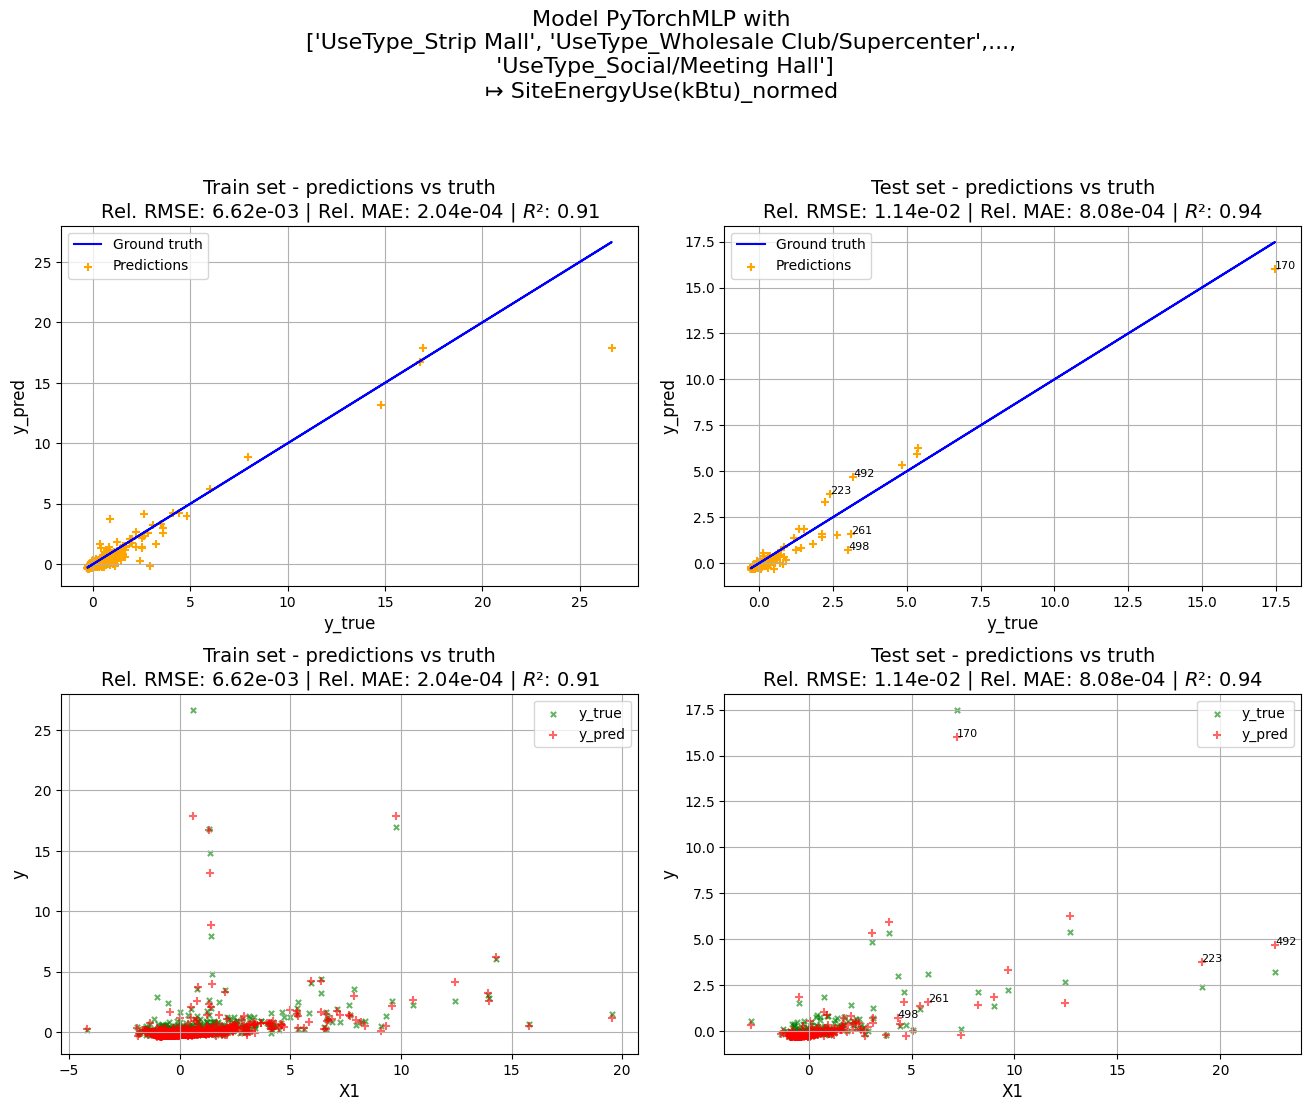

5 worst predictions : [498, 170, 261, 492, 490]


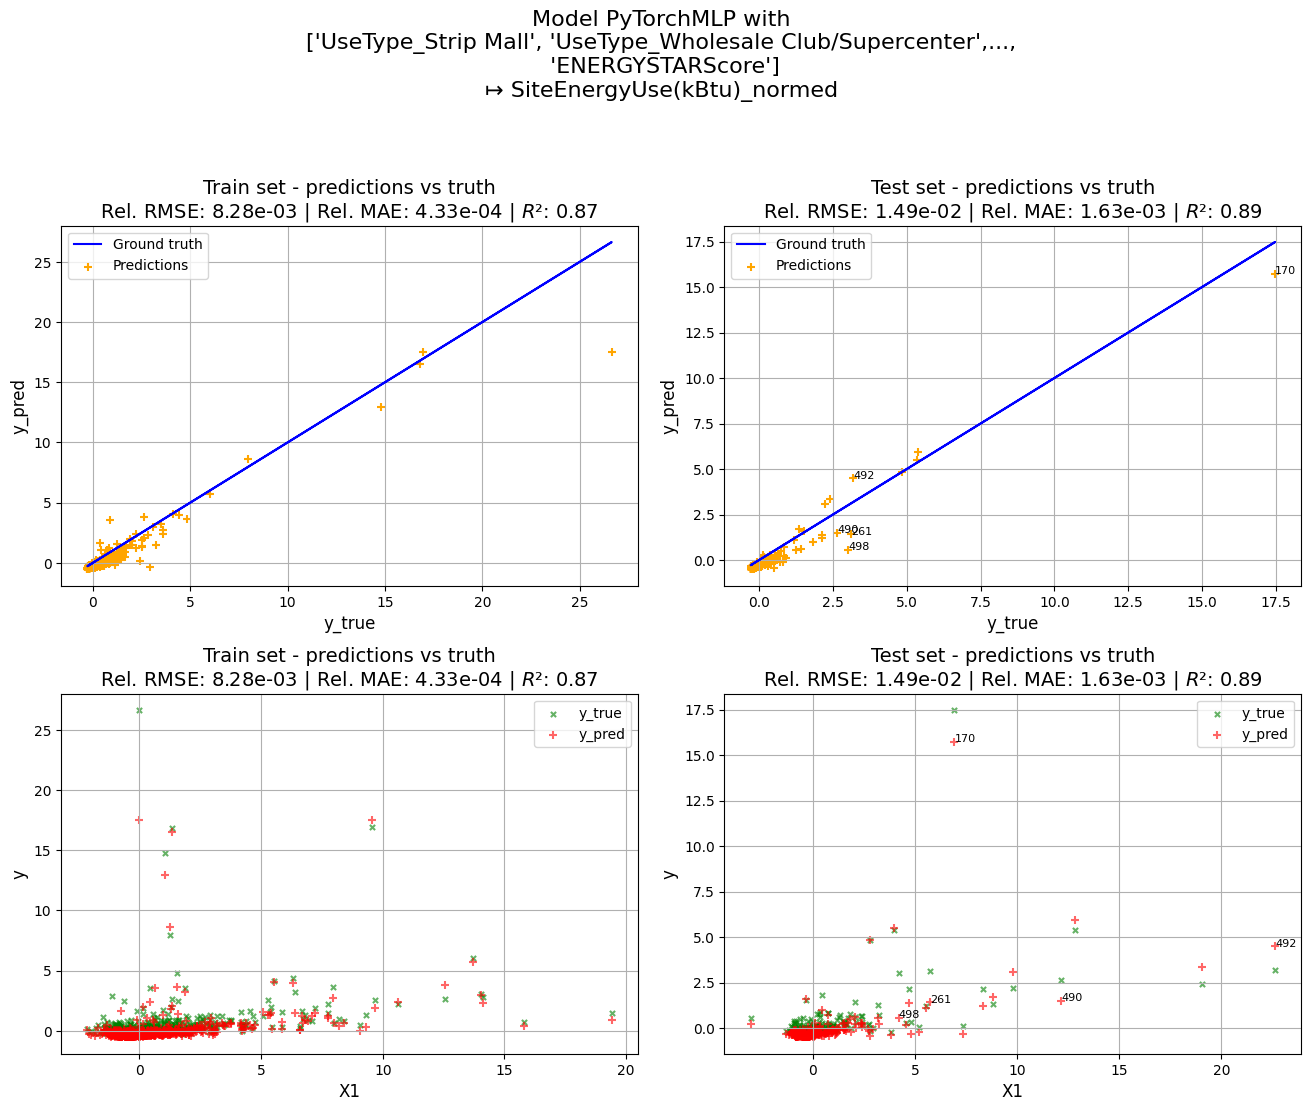

In [142]:
# xlim_train = [0., 0.75e8]
# ylim_train = [0., 0.75e8]
# xlim_test  = [0., 2.e6]
# ylim_test  = [0., 2.e8]
display_reg_results(df_doe, display_all=True, criteria='Test neg_root_mean_squared_error')

## Feature importance

We use SHAP.

In [143]:
shap.initjs()

In [144]:
def get_reg_feat_importance(df_doe):
    winner = df_doe.loc[df_doe['Test neg_root_mean_squared_error'].astype(float)==df_doe['Test neg_root_mean_squared_error'].astype(float).min()]
    explainer = None
    shap_values = None

    # for ind in range(df_doe.shape[0]):
    for ind in [winner.index[0]]:
        problem = df_doe.iloc[ind]
        res           = algos_results[ind] # int(winner.index.values)
        algo          = problem['Algorithm']['surname']
        X_train       = res['X_train']
        y_train       = res['y_train']
        X_test        = res['X_test']
        y_test        = res['y_test']
        y_train_pred  = res['y_train_pred']
        y_test_pred   = res['y_test_pred']
        feat_cols     = problem['Variables']['categ_cols'] + problem['Variables']['num_cols']
        feat_cols_enc = res['Column names']
        pipeline      = res['model'].best_estimator_
        s = f"{algo} | {pipeline} :\n"

        X_sampled = X_train.sample(100, random_state=10)
        X_train_enc = pipeline['preprocessor'].transform(X_train)
        X_sampled_enc = pipeline['preprocessor'].transform(X_sampled)
        X_sampled_enc = pd.DataFrame(X_sampled_enc, columns=feat_cols_enc)
    #     X_train = pd.DataFrame(X_sampled_enc, columns=feat_cols)

        # Display the model caracteristics
        print(s+'-'*(min(124,len(s)-3)))

        if algo in ['XGBoost','LightGBM','RandomForest']:
    #         explainer = shap.TreeExplainer(res['model'].best_estimator_, X_train_enc)
            explainer = shap.Explainer(pipeline.named_steps["model"]) # GradientExplainer
    #         shap_values = explainer.shap_values(X_sampled_enc, check_additivity=False)
            shap_values = explainer(X_sampled_enc).values
        elif algo in ['RegLinTheBest','RidgeRegLin','LassoRegLin','ElasticNetRegLin']:
    #         explainer = shap.LinearExplainer(res['model'].best_estimator_, X_train_enc)
    #         explainer = shap.LinearExplainer(pipeline.named_steps["model"]) # GradientExplainer
    #         explainer = shap.LinearExplainer(pipeline["model"]) # GradientExplainer
    #         shap_values = explainer.shap_values(X_sampled)

            explainer = shap.LinearExplainer(pipeline['model'], X_train_enc) # GradientExplainer ## OK ##
            shap_values = explainer(X_sampled_enc).values ## OK ##
    #         explainer = shap.Explainer(pipeline['model'].predict, X_train_enc)
    #         shap_values = explainer(X_sampled_enc).values

        elif algo in ['LinearSVR','kNN']:
    #         explainer = shap.KernelExplainer(res['model'].best_estimator_, X_train_enc)
            explainer = shap.KernelExplainer(pipeline.named_steps["model"])
            shap_values = explainer.shap_values(X_sampled, check_additivity=False)[0]
        elif algo in ['SklMLP', 'PyTorchMLP']:
            X_train_enc = pipeline['preprocessor'].transform(X_train)
            X_train_enc = pd.DataFrame(X_train_enc, columns=feat_cols_enc)

            X_train_enc_summary = shap.kmeans(X_train_enc, 10)
    #         explainer = shap.KernelExplainer(pipeline.named_steps["model"].predict, X_train_summary)
    #         explainer = shap.KernelExplainer(pipeline.predict, X_train)
            explainer = shap.KernelExplainer(pipeline['model'].predict, X_train_enc_summary)
    #         shap_values = explainer.shap_values(X_sampled)
            shap_values = explainer.shap_values(X_sampled_enc)[0]
        else:
            print(f"Algorithm {algo} not managed!")
            continue
    return X_sampled_enc, feat_cols_enc, explainer, shap_values

In [145]:
def display_reg_feat_importance(X_sampled_enc, feat_cols_enc, explainer, shap_values, target_col):
    if explainer is None:
        print(f"No explainer to display.")
        return
    
    shap.force_plot(explainer.expected_value, shap_values[0, :], X_sampled_enc.iloc[0,:], matplotlib=True)
    shap.force_plot(explainer.expected_value, shap_values, X_sampled_enc)
#     shap.force_plot(explainer.expected_value, shap_values, X_train)
#     shap.summary_plot(shap_values, X_sampled_enc)
    shap.summary_plot(shap_values, X_sampled_enc, plot_type="bar")
#     shap.waterfall_plot(shap_values) # Ne fonctionne pas
#     shap.waterfall_plot(explainer.expected_value, shap_values[0,:], X_sampled_enc.iloc[0,:])

    # Average the samples
    shap_values_moy = abs(shap_values).mean(axis=0)
    grouped_influences = PwePwocess.influenceCatVal(feat_cols_enc, shap_values_moy)
    df_fi = pd.Series(grouped_influences)
    df_fi.plot(kind='barh', color='firebrick', figsize=(5, 3)) # firebrick, salmon
    plt.xlabel('mean(|SHAP value|, grouped for categorial features)');
    plt.title(f'Feature importances on {target_col}');
    plt.grid('on')
    plt.show()

In [146]:
X_sampled_enc, feat_cols_enc, explainer, shap_values = get_reg_feat_importance(df_doe)

PyTorchMLP | Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['UseType_Strip Mall',
                                                   'UseType_Wholesale '
                                                   'Club/Supercenter',
                                                   'UseType_Residential Care '
                                                   'Facility',
                                                   'UseType_Other - Services',
                                                   'UseType_Distribution '
                                                   'Center',
                                                   'UseType_Automobile '
                                                   'Dealership',
               

  0%|          | 0/100 [00:00<?, ?it/s]

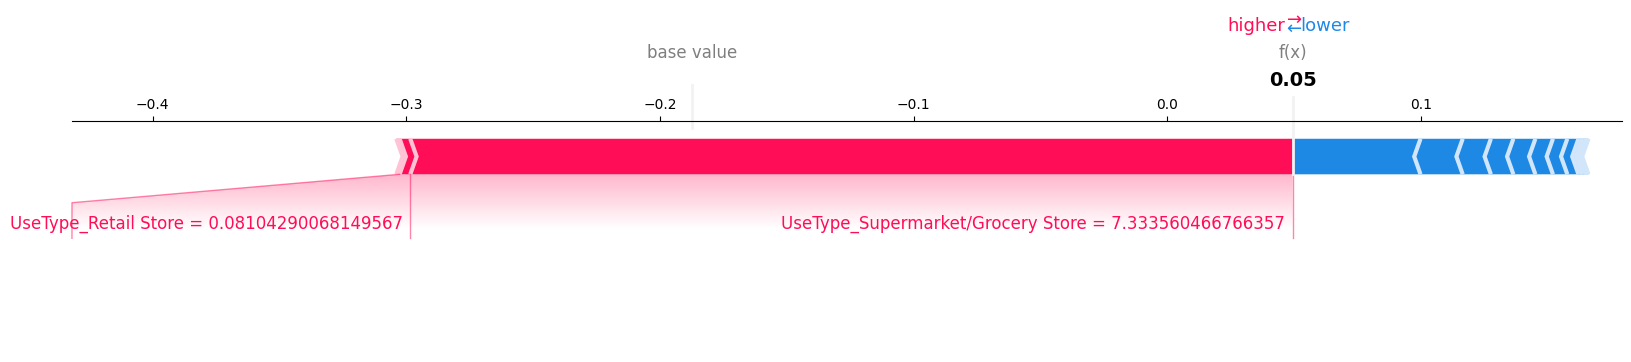

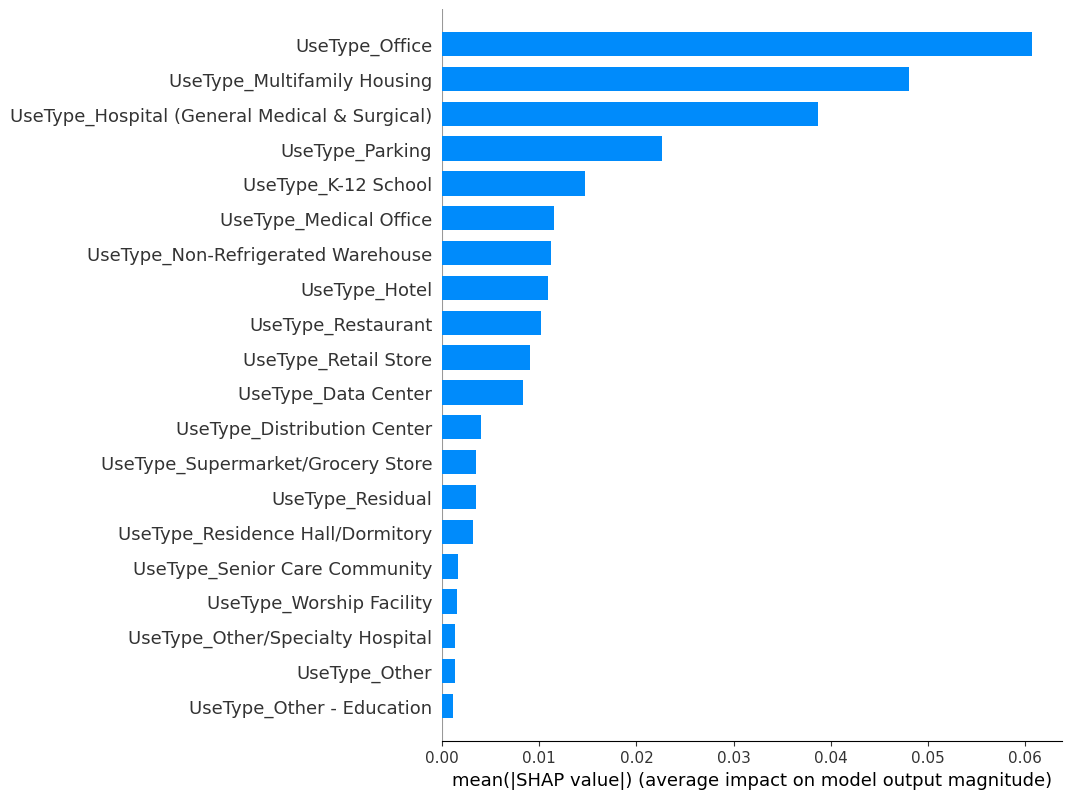

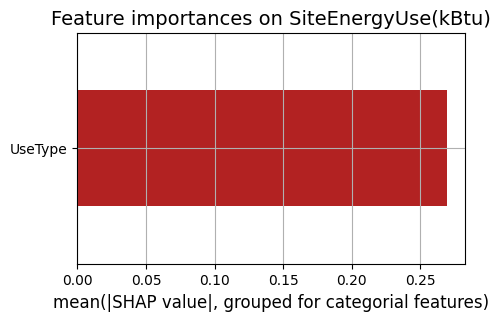

In [147]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

display_reg_feat_importance(X_sampled_enc, feat_cols_enc, explainer, shap_values, target_col)

### Average contribution of `'ENERGYSTARSCORE'` to the $R^2$ score

The DOE is normally constructed alternating "without"/"with" the `'ENERGYSTARSCORE'` variable.

In [148]:
gain_ES = []
for ii in range(df_doe.shape[0]//2):
    ind1 = 2*df_doe.index[ii]
    ind2 = 2*df_doe.index[ii]+1
    R2_wout = float(df_doe.loc[ind1,'Test r2'])
    R2_with = float(df_doe.loc[ind2,'Test r2'])
    gain_ES.append(R2_with-R2_wout)
    pass
gain_ES = np.array(gain_ES)
mean_gain_ES = gain_ES.mean()
print(mean_gain_ES)

-0.044700378177279454


The `ENERGYSTARSCORE` variable lowers the $R^2$ by 4 points with the PyTorch model.

# Target `TotalGHGEmissions`

In [149]:
target_col = 'TotalGHGEmissions'

## Launching the algorithms

In [150]:
problem_kind = 'regression'
scores = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']

In [151]:
target_col_norm = target_col+'_normed'
y_normer = StandardScaler()
df_work[target_col_norm] = y_normer.fit_transform(df_work[[target_col]])
# df_work[target_col_norm] = df_work[[target_col]]

In [152]:
df_doe, algos_results, s, best_mdl, best_mdl_name = \
        MLstuff.regression_doe(df_work, df_doe_init,
                               target_col_norm, problem_kind,
                               scores,
                               encode_y=ENCODE_Y)

Size of the regression train set : (2439, 120)
Explanatory variables            : ['UseType_Strip Mall', 'UseType_Wholesale Club/Supercenter', 'UseType_Residential Care Facility', 'UseType_Other - Services', 'UseType_Distribution Center', 'UseType_Automobile Dealership', 'UseType_Non-Refrigerated Warehouse', 'UseType_Laboratory', 'UseType_Supermarket/Grocery Store', 'UseType_Enclosed Mall', 'UseType_Performing Arts', 'UseType_Restaurant', 'UseType_Multifamily Housing', 'UseType_Courthouse', 'UseType_Manufacturing/Industrial Plant', 'UseType_Retail Store', 'UseType_K-12 School', 'UseType_Pre-school/Daycare', 'UseType_Financial Office', 'UseType_None', 'UseType_Other - Recreation', 'UseType_Refrigerated Warehouse', 'UseType_Data Center', 'UseType_Outpatient Rehabilitation/Physical Therapy', 'UseType_Other - Lodging/Residential', 'UseType_College/University', 'UseType_Repair Services (Vehicle, Shoe, Locksmith, etc)', 'UseType_Office', 'UseType_Food Sales', 'UseType_Other - Public Services

In [153]:
df_doe

,Algorithm,Encoder,Scaler,Ignored train index,Variables,Best params,Scoring,Train neg_root_mean_squared_error,Train relative neg_root_mean_squared_error,Test neg_root_mean_squared_error,Test relative neg_root_mean_squared_error,Train neg_mean_absolute_error,Train relative neg_mean_absolute_error,Test neg_mean_absolute_error,Test relative neg_mean_absolute_error,Train r2,Train relative r2,Test r2,Test relative r2,Test adj r2,Elapsed time
0,"{'surname': 'PyTorchMLP', 'class': <class 'sko...","OneHotEncoder(handle_unknown='ignore', sparse=...",<class 'sklearn.preprocessing._data.StandardSc...,None,"{'categ_cols': [], 'num_cols': ['UseType_Strip...","{'model__lr': 0.05, 'model__max_epochs': 2000,...",neg_root_mean_squared_error,0.333862,0.007551,0.300818,0.013670,0.190911,0.000440,0.197015,0.001702,0.888748,N/A,0.908798,N/A,0.905603,693.926466
1,"{'surname': 'PyTorchMLP', 'class': <class 'sko...","OneHotEncoder(handle_unknown='ignore', sparse=...",<class 'sklearn.preprocessing._data.StandardSc...,None,"{'categ_cols': [], 'num_cols': ['UseType_Strip...","{'model__lr': 0.05, 'model__max_epochs': 2000,...",neg_root_mean_squared_error,0.321943,0.007282,0.287064,0.013045,0.170405,0.000392,0.178842,0.001545,0.896549,N/A,0.916947,N/A,0.913992,685.690239


In [154]:
winner = df_doe.loc[df_doe['Test neg_root_mean_squared_error'].astype(float)==df_doe['Test neg_root_mean_squared_error'].astype(float).min()]
winner.loc[winner.index, ['Algorithm', 'Variables', 'Test r2']].values

array([[{'surname': 'PyTorchMLP', 'class': <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
          module=<class '__main__.PyTorchMLP'>,
        ), 'param_grid': {'module__n1': [200], 'module__n2': [200], 'module__n3': [50], 'max_epochs': [2000], 'optimizer': [<class 'torch.optim.sgd.SGD'>], 'lr': [0.05], 'optimizer__weight_decay': [0.0, 0.0001, 0.001, 0.01]}},
        {'categ_cols': [], 'num_cols': ['UseType_Strip Mall', 'UseType_Wholesale Club/Supercenter', 'UseType_Residential Care Facility', 'UseType_Other - Services', 'UseType_Distribution Center', 'UseType_Automobile Dealership', 'UseType_Non-Refrigerated Warehouse', 'UseType_Laboratory', 'UseType_Supermarket/Grocery Store', 'UseType_Enclosed Mall', 'UseType_Performing Arts', 'UseType_Restaurant', 'UseType_Multifamily Housing', 'UseType_Courthouse', 'UseType_Manufacturing/Industrial Plant', 'UseType_Retail Store', 'UseType_K-12 School', 'UseType_Pre-school/Daycare', 'UseType_Financial Office', 'UseType_None', 'Use

We discard experiments with simple linear regression because it disturbs the average results:

In [155]:
# df_doe_filtered = MLstuff.result_table_filter_algo(df_doe, [LinearRegression], check_class=True)
df_doe_filtered = df_doe.loc[df_doe['Test r2']>0.]

### Effect of the `'ENERGYSTARScore'` variable on the different scores:

In [156]:
df_comp_ES = MLstuff.result_table_wiwo_var(df_doe_filtered,'ENERGYSTARScore',scores)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,-0.013754,-0.018172,0.008149


In [157]:
df_comp_ES = MLstuff.result_table_wiwo_var(df_doe_filtered,'SteamUsed',scores)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,NaN,NaN,NaN


In [158]:
df_comp_ES = MLstuff.result_table_wiwo_var(df_doe_filtered,'YearBuilt',scores)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,NaN,NaN,NaN


In [159]:
df_comp_ES = MLstuff.result_table_wiwo_var(df_doe_filtered,'Neighborhood',scores)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,NaN,NaN,NaN


In [160]:
df_comp_ES = MLstuff.result_table_compare_2_vals(df_doe_filtered,'Scaler',MinMaxScaler,StandardScaler,scores, check_class=True)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,NaN,NaN,NaN


The `StandardScaler` scaler makes much less gain for the $R^2$ compared to the `MinMaxScaler` than for energy consumption.

In [161]:
df_comp_ES = MLstuff.result_table_compare_2_vals(df_doe_filtered,'Ignored train index',None,list(leverage_index),scores, check_class=False)
df_comp_ES

,neg_root_mean_squared_error gain,neg_mean_absolute_error gain,r2 gain
0,NaN,NaN,NaN


Ah, it seems that removing the levers slightly degrades the RMSE and the $R^2$, on all the algos.

In [162]:
N = 2
doe_top = MLstuff.result_table_top_N(df_doe, 'Test r2', N)
doe_top.to_csv(f"doe_top_{N}_{target_col}_R2adj.csv",sep=';')
doe_top

,Algorithm,Variables,Scaler,Ignored train index,Test neg_root_mean_squared_error,Test neg_mean_absolute_error,Test r2,Test adj r2,Elapsed time
0,PyTorchMLP,"[UseType_Strip Mall, UseType_Wholesale Club/Su...",StandardScaler,None,0.2871,0.1788,0.9169,0.9140,685.6902
1,PyTorchMLP,"[UseType_Strip Mall, UseType_Wholesale Club/Su...",StandardScaler,None,0.3008,0.1970,0.9088,0.9056,693.9265


### Visualizations of results

5 worst predictions : [498, 492, 170, 2557, 1259]


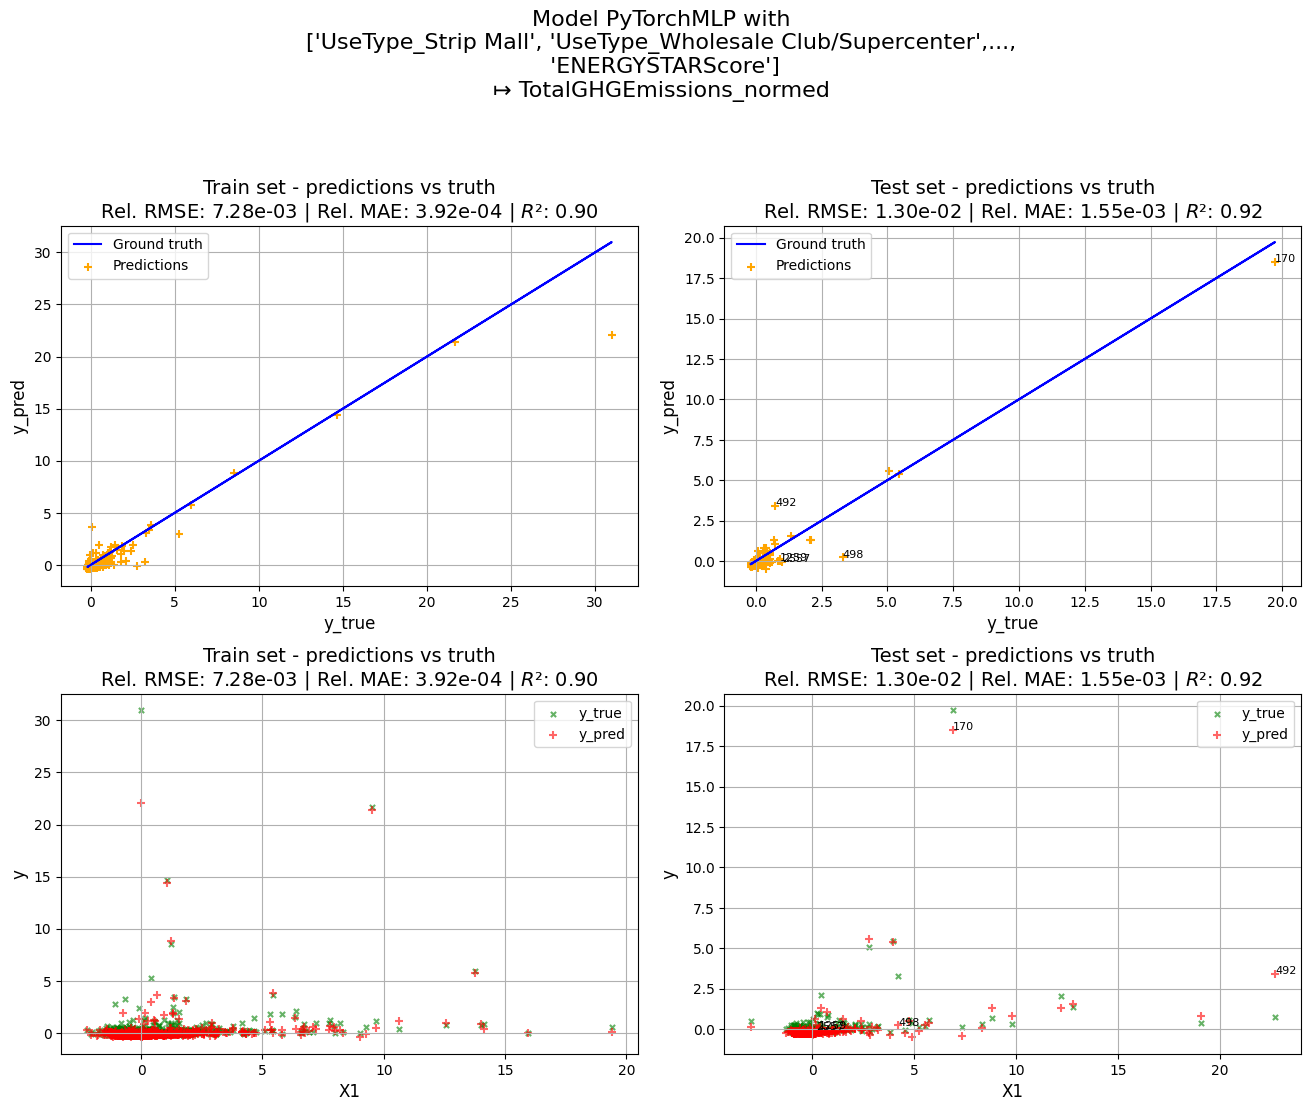

In [163]:
display_reg_results(df_doe)

## Feature importance

In [164]:
X_sampled_enc, feat_cols_enc, explainer, shap_values = get_reg_feat_importance(df_doe)

PyTorchMLP | Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['UseType_Strip Mall',
                                                   'UseType_Wholesale '
                                                   'Club/Supercenter',
                                                   'UseType_Residential Care '
                                                   'Facility',
                                                   'UseType_Other - Services',
                                                   'UseType_Distribution '
                                                   'Center',
                                                   'UseType_Automobile '
                                                   'Dealership',
               

  0%|          | 0/100 [00:00<?, ?it/s]

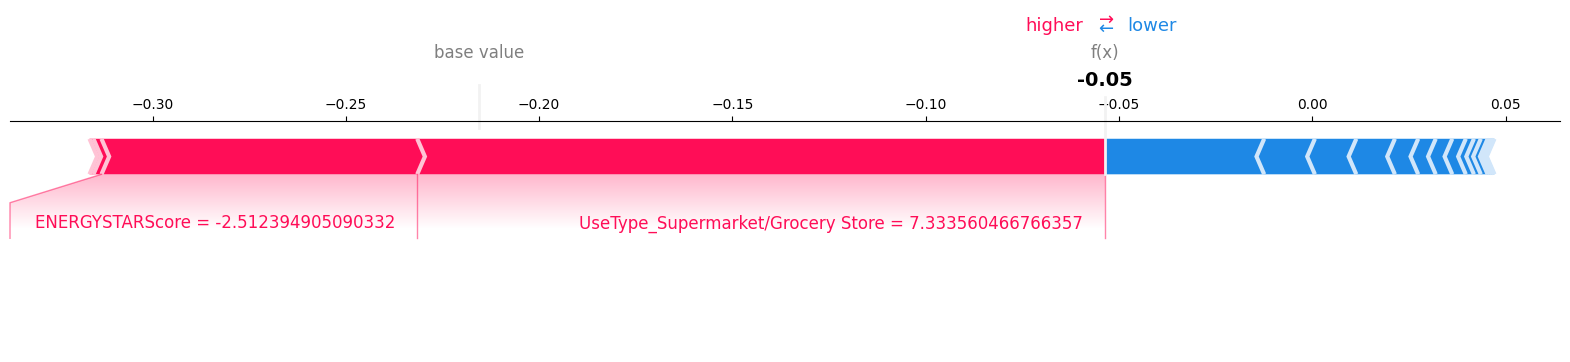

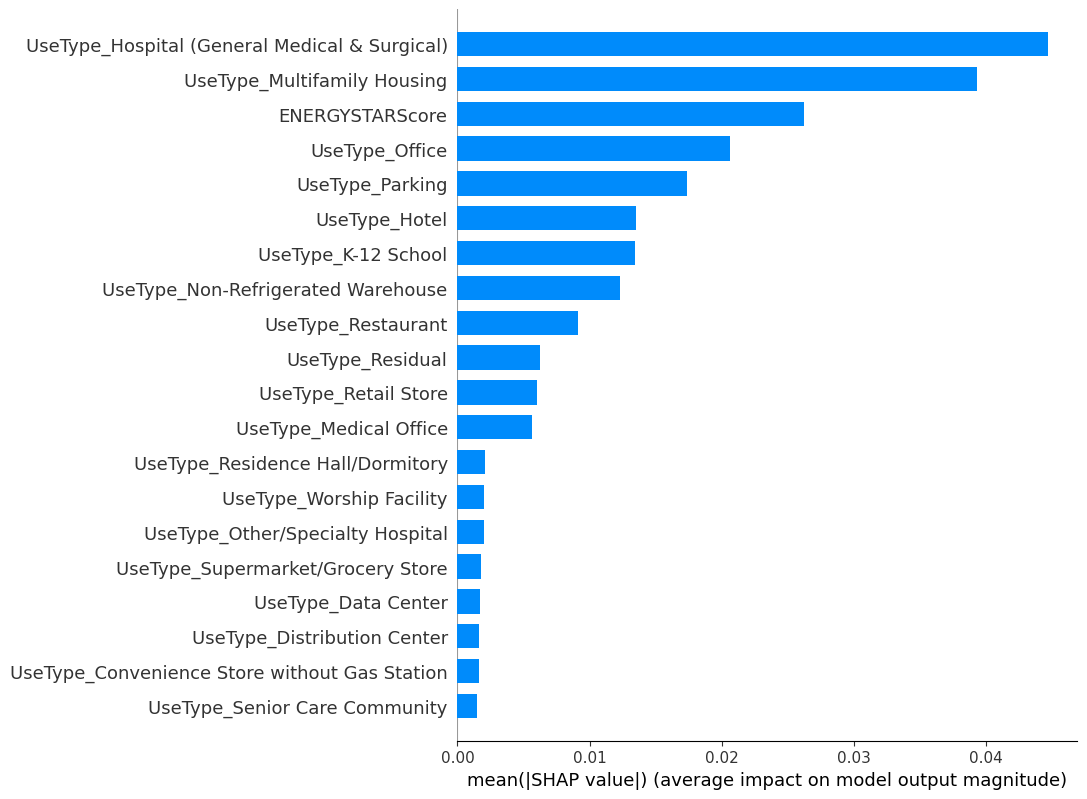

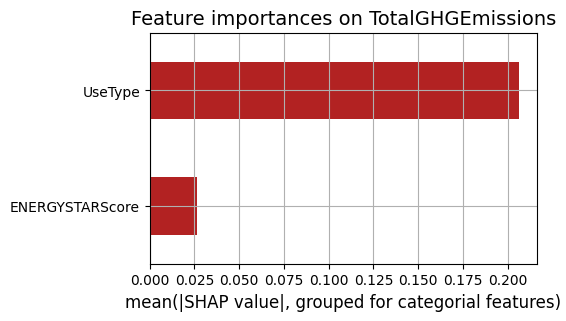

In [165]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

display_reg_feat_importance(X_sampled_enc, feat_cols_enc, explainer, shap_values, target_col)

### Average contribution of `'ENERGYSTARSCORE'` to the $R^2$ score

The DOE is normally constructed alternating "without"/"with" the `'ENERGYSTARSCORE'` variable.

In [166]:
gain_ES = []
for ii in range(df_doe.shape[0]//2):
    ind1 = 2*df_doe.index[ii]
    ind2 = 2*df_doe.index[ii]+1
    R2_wout = float(df_doe.loc[ind1,'Test r2'])
    R2_with = float(df_doe.loc[ind2,'Test r2'])
    gain_ES.append(R2_with-R2_wout)
    pass
gain_ES = np.array(gain_ES)
mean_gain_ES = gain_ES.mean()
print(mean_gain_ES)

0.008149414767751995


The `ENERGYSTARSCORE` variable improves the $R^2$ by 1 point with the PyTorch model.